For the current problem we need to determine a model that will predict the prices for houses depending on the data gathered from other housing sales. The complete description of the characteristics that were gathered in the process is available on [this file](https://drive.google.com/open?id=1uOU5Ps5T3Yiy8IsgyIRWfIvht7C47r9L), please consult it for more info.

We'll start by uploading the file containing the housing sales information, which will be used to train and validate the prediction model.

In [59]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

After the file has been uploaded, we can proceed on importing the necessary modules for the process of creating the model.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, Imputer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

We load the csv file containing the data. We can have a glimpse of its contents with the `head` function, which will give us a view on the first 5 rows of the data set that we just loaded.

In [105]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


As we can see on the table above, and from the information of the features from this dataset (please refer to [this file](https://drive.google.com/open?id=1uOU5Ps5T3Yiy8IsgyIRWfIvht7C47r9L)), we can see that many of the columns, although they contain `NaN` values (a.k.a, null values on the dataset), many of these correspond to an actual mapping of a feature(e.g., a category for `NA` when the feature does not apply). An example of this is the feature `BsmtQual`, which evaluates the quality of the house's basement, giving a value of `NA` when the house does not include a basement.

This means there is a further study to be made, first to determine what are the features that have a value of `NA` as a valid entry on their data, and second to convert these values into something other than `NaN`, in order for the pre-processing tasks to work correctly on these features.


---


Before that, let's define a function that, given a dataset and a series of features, it will convert all instances of `NaN` into the string `NA`, making the pre-processing task possible.

In [0]:
def convert_nan_to_string(df,keys):
    f = lambda x: str(x) + ""
    g = lambda x: "NA" if (x.lower() == "nan"  or x == None) else x
    
    for key in keys:
        df[key] = df[key].apply(f).apply(g)
    
    return df

Moreover, we will define a function that will take all categorical features of the dataset, and convert them to numerical values, which can be pre-processed and placed in the model for training.

This function will combine the `NaN` processing of the features, as well as removing all features that present a `NaN` value after the processing, removing all missing data from the dataset.

In [0]:
def convert_categorical_features(df, keys, nan_keys, drop_keys):
    df = convert_nan_to_string(df, nan_keys)
    df.dropna(subset=drop_keys, how='any', inplace=True)
    le = LabelEncoder()
    for key in keys:
        df[key] = le.fit_transform(df[key])
    return df

By studying the dataset and its features, we can now define what are the categorical values to take into account and also what are the features that contain `NA` as a valid entry, converting them and then enconding them to be used in the pre-processing.


---

We can see the result of the transformation that we did on these categorical features, meaning we are now ready to create a model.

In [108]:
categorical_feats = ['MSSubClass', 'MSZoning', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition']
nan_feats = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
             "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", 
             "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
drop_feats = ["MasVnrType", "Electrical"]
df = convert_categorical_features(df, categorical_feats, nan_feats, drop_feats)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,5,3,65.0,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,208500
1,2,0,3,80.0,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,181500
2,3,5,3,68.0,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,223500
3,4,6,3,60.0,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,140000
4,5,5,3,84.0,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,250000


We will define our predictor and output columns, and create our variables based on them

In [0]:
train_cols = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'SaleType',
       'SaleCondition']
predict_col = 'SalePrice'
categorical_feats = ['MSSubClass', 'MSZoning', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition']
X = df[train_cols]
y = df[predict_col]

In order to do handle the categorical features of our model, we need to do a One-Hot-Encoding on the variables in question. In order to do this we need to define what are the columns containing categorical values, and get their indices in order to use them in the One-Hot-Encoding process.

In [0]:
columns = X.columns
idx_categorical_feats = [np.argwhere(columns == i)[0][0] for i in categorical_feats]

We can proceed on dividing the variables for training and testing purposes.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

We can create our first model, which will include all pre-processing tasks on the variables

In [0]:
model = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy='median')),
    ('encoder', OneHotEncoder(categorical_features=idx_categorical_feats, handle_unknown='ignore')),
    ('scaler', MaxAbsScaler()),
    ('regressor', Lasso(fit_intercept=True))
])

Let's fit our model with the training parameters and let it try and predict the values for our training and testing sets. This is in order to get the prediction error for both training and testing using the `mean_absolute_error` metric

In [113]:
model.fit(X_train, y_train)
y_train_pred= model.predict(X_train)
y_test_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


We can then calculate the `mean_absolute_error` for both the training and testing sets, as well as the scoring for the model,  which will give us a value of the overall accuracy.

In [114]:
mae_train = mean_absolute_error(y_pred=y_train_pred, y_true=y_train)
mae_test  = mean_absolute_error(y_pred=y_test_pred, y_true=y_test)
msg = "Mean Absolute Error with basic model: {}"
print(msg.format(mae_train))
print(msg.format(mae_test))
print("Model train score: {}".format(model.score(X_train, y_train)))
print("Model test score: {}".format(model.score(X_test, y_test)))

Mean Absolute Error with basic model: 9683.873548336414
Mean Absolute Error with basic model: 20697.70037498356
Model train score: 0.9657959584050217
Model test score: 0.8123483656390769


As we can see from the information above the model behaved very well for the training dataset, but when it came to the testing dataset its performance was poor at best, leading to a lower accuracy on testing than on training.
This is a telltale sign of data overfitting, which means we need a better approach on our model selection process.

In order to avoid having to select and cross-validate various models by hand we can do an automated search and cross validation which will then give us the best possible model and use it as an improvement for our estimations.
We will use a `RandomSearchCV`, since it allows for a faster search and good results with the caveat that it will not do an in-depth search through all the parameter space but rather select several samples and compare them. In theory it means that the search might yield sub-optimal results when compared with an in-depth approach but in practice, given a sufficiently narrow parameter space, it can yield a result that works best for our computing or time constraints.

---

For our specific model, the parameter that we will vary is the `alpha`, which serves as a scale for the weights defined by the cost function. For more information you can see the optimization objective for the Lasso function [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [0]:
param_space = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

rand_search = RandomizedSearchCV(param_distributions=param_space, estimator=model, scoring='neg_mean_absolute_error', n_iter=4, cv=5, return_train_score=True)

We will then start the search of the best model, defined by the parameters and the scoring passed to the `RandomSearchCV`

In [116]:
rand_search.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('encoder', OneHotEncoder(categorical_features=[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 57, 58, 61, ...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=4, n_jobs=1,
          param_distributions={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=0)

We see that an estimator was found, and we can check what its score is (a.k.a, the `mean_absolute_error`). We need to recall that, since the `RandomSearchCV` gives greater importance to greater values of the metric, we needed to pass the `neg_mean_absolute_error` in order to minimize the absolute error.

In [117]:
rand_search.best_score_

-16121.234412392263

We can also check what the best parameters from our parameter space are. In our case, only the `alpha` parameter was passed, so it is the only value in the dictionary of parameters.

In [118]:
rand_search.best_params_

{'regressor__alpha': 100}

This function will help us see more clearly the results of the random search. This will show us the mean score for each iteration between all cross-validations, as well as the standard deviation for that same iteration

In [0]:
def pretty_print_split_results(results_dict, n_iter):
  iter_range = range(1, n_iter+1)
  print_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  line_styles = ['-', '--', '-.', ':']
  marker_styles= ['s','o']
  fig = plt.figure(figsize=(9,7))
  ax = fig.add_subplot(111)
  
  mean_test_score = results_dict['mean_test_score']
  std_test_score  = results_dict['std_test_score']
  
  mean_train_score = results_dict['mean_train_score']
  std_train_score = results_dict['std_train_score']
  
  ax.plot(
    iter_range, mean_test_score, color="b",
    marker="s", linestyle="--", markersize="5",
    label="Mean Test Score"
  )
  
  ax.fill_between(
    iter_range, mean_test_score + std_test_score, mean_test_score - std_test_score,
    alpha=0.25, color="b"
  )
  
  ax.plot(
    iter_range, mean_train_score, color="g",
    marker="o", linestyle="-", markersize="5",
    label="Mean Train Score"
  )
  
  ax.fill_between(
    iter_range, mean_train_score + std_train_score, mean_train_score - std_train_score,
    alpha=0.25, color="g"
  )
  
  ax.set_xlabel("Iterations")
  ax.set_ylabel("Scores")
  ax.set_ylim(auto=True)
  ax.grid(linestyle="--")
  ax.legend(loc="lower right")
  

With this function then we can see the process for the random search to select the best model from a random selection, and how each result varied for each iteration


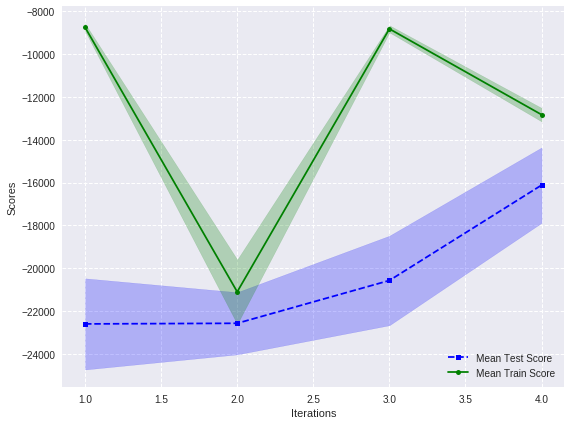

In [120]:
pretty_print_split_results(rand_search.cv_results_, rand_search.get_params()['n_iter'])

We can now proceed to get the best estimator selected by the random search, and check the values for the training and test datasets, and see what the accuracy for this model will be

In [0]:
rand_model = rand_search.best_estimator_
y_train_pred= rand_model.predict(X_train)
y_test_pred = rand_model.predict(X_test)

In general, we should see that there was an improvement on the scores from just the sole estimator that we defined, since it was chosen from the cross-validation process of the `RandomSearchCV`, but we need to keep in mind that this might not always be the case, again from the intrinsic randomness on the process.

In [122]:
mae_train = mean_absolute_error(y_pred=y_train_pred, y_true=y_train)
mae_test  = mean_absolute_error(y_pred=y_test_pred, y_true=y_test)
msg = "Mean Absolute Error with Lasso model from random search: {}"
print(msg.format(mae_train))
print(msg.format(mae_test))
print("Model train score: {}".format(rand_model.score(X_train, y_train)))
print("Model test score: {}".format(rand_model.score(X_test, y_test)))

Mean Absolute Error with Lasso model from random search: 13249.918325626511
Mean Absolute Error with Lasso model from random search: 18049.70381408049
Model train score: 0.9356469689943616
Model test score: 0.8471608172298151


We will now re-do the same process, this time selecting a non-linear model. Since we have a lot of categorical data, the best model to deal with this kind of data is a `RandomForestRegressor`, since decision trees are very well equiped to deal with incoming categorical data.

We re-define the parameter space to search the best `RandomForestRegressor`, and for this we will vary 2 hyper-parameters for forests: `n_estimators`, which is the number of trees in the forest; `max_depth`, which is the number of layers that a given tree will have to make its decision.

In [0]:
param_space = {
    'regressor__n_estimators': [1, 10, 20, 50, 100],
    'regressor__max_depth': [1, 2, 5, 10, 20]
}

model2 = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy='median')),
    ('regressor', RandomForestRegressor())
])

rand_search = RandomizedSearchCV(param_distributions=param_space, estimator=model2, scoring='neg_mean_absolute_error', n_iter=4, cv=5, return_train_score=True)

We then proceed to train our new random search with the `RandomForestRegressor` model

In [124]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decre...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=4, n_jobs=1,
          param_distributions={'regressor__n_estimators': [1, 10, 20, 50, 100], 'regressor__max_depth': [1, 2, 5, 10, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=0)

We can check the best score for this given search

In [125]:
rand_search.best_score_

-17707.49119748575

And we see that, since our parameter space consisted on 2 variables, the best parameters dictionary now contains 2 different keys

In [126]:
rand_search.best_params_

{'regressor__max_depth': 10, 'regressor__n_estimators': 100}

We can see the variation for each iteration on this `RandomForestRegressor` search

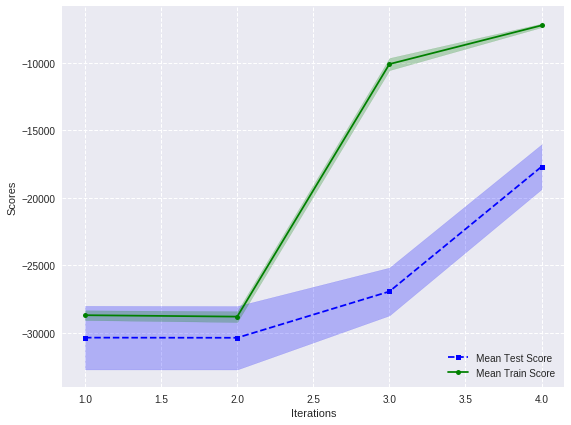

In [127]:
pretty_print_split_results(rand_search.cv_results_, rand_search.get_params()['n_iter'])

We can now proceed to get the best estimator selected by the random search, and check the values for the training and test datasets, and see what the accuracy for this model will be

In [0]:
rand_model = rand_search.best_estimator_
y_train_pred= rand_model.predict(X_train)
y_test_pred = rand_model.predict(X_test)

Since the `RandomForestRegressor` is prone to overfitting, the results that we get here might be worse than our previous search. This could be mitigated either with more data, or re-defining the parameter space in order to mitigate the overfitting efect

In [129]:
mae_train = mean_absolute_error(y_pred=y_train_pred, y_true=y_train)
mae_test  = mean_absolute_error(y_pred=y_test_pred, y_true=y_test)
msg = "Mean Absolute Error with Random Forest model from random search: {}"
print(msg.format(mae_train))
print(msg.format(mae_test))
print("Model train score: {}".format(rand_model.score(X_train, y_train)))
print("Model test score: {}".format(rand_model.score(X_test, y_test)))

Mean Absolute Error with Random Forest model from random search: 7474.1341743955545
Mean Absolute Error with Random Forest model from random search: 20520.47558404813
Model train score: 0.9761437873524401
Model test score: 0.8133913948603483


This was all done doing random searches, but I can easily feel unhappy with the results, and given the fact that the searches we just did were done at random, I would like to do a more thorough search of the model. In that case we can use `GridSearchCV` which will make a thorough search of the hyperparameters defined.

Let's try a `GridSearchCV` on the `Lasso` model, and check how it changes from the random search made earlier.

We define the parameter space again, only this time we'll pass it to a given `GridSearchCV`

In [0]:
param_space = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(param_grid=param_space, estimator=model, scoring='neg_mean_absolute_error', cv=5, return_train_score=True)

Since now we're doing an exhaustive search, the training of the model will take longer, but since it's taking into account all possible combinations, we can be sure that the best model given the parameter space we're using is found through this method.

In [131]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('encoder', OneHotEncoder(categorical_features=[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 57, 58, 61, ...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

If the score is similar to the one given by the random search it could be due to the limited parameter space that was passed to both functions. The results could vary though, as the cross-validation was done through more iterations on the `GridSearchCV` than on the `RandomSearchCV`, so it is possible that the score for this model might be better than the previous search method.

In [132]:
grid_search.best_score_

-16121.234412392263

For similar reasons, the best parameters might coincide with the ones given by the random search because of the limited parameter space that the search was executed on

In [133]:
grid_search.best_params_

{'regressor__alpha': 100}

We can see the results of the grid search, and what steps it took to improve the score of the estimator it found

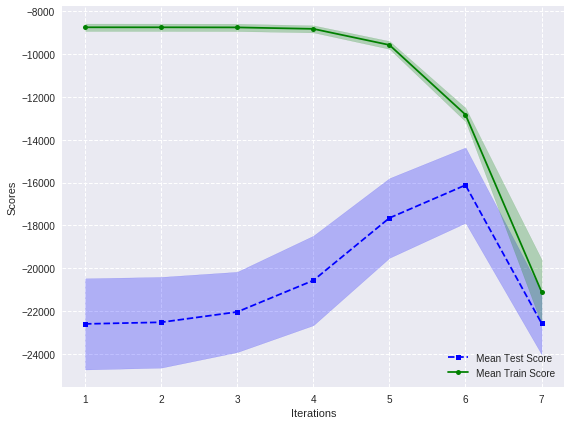

In [135]:
pretty_print_split_results(grid_search.cv_results_, len(grid_search.cv_results_['params']))

We proceed then to obtain the best model and calculate the predictions for both training and test datasets

In [0]:
best_model = grid_search.best_estimator_
y_train_pred= best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [137]:
mae_train = mean_absolute_error(y_pred=y_train_pred, y_true=y_train)
mae_test  = mean_absolute_error(y_pred=y_test_pred, y_true=y_test)
msg = "Mean Absolute Error with Lasso model from grid search: {}"
print(msg.format(mae_train))
print(msg.format(mae_test))
print("Model train score: {}".format(best_model.score(X_train, y_train)))
print("Model test score: {}".format(best_model.score(X_test, y_test)))

Mean Absolute Error with Lasso model from grid search: 13249.918325626511
Mean Absolute Error with Lasso model from grid search: 18049.70381408049
Model train score: 0.9356469689943616
Model test score: 0.8471608172298151


The result from this estimator may result pretty similar to the one thrown by the random search. This is due to the small parameter space, meaning that the probabilities of the 2 methods throwing the same model are higher.

Finally we will do a `GridSearchCV` to find the best possible `RandomForestRegressor` model. We will vary the `max_depth` and `n_estimators` parameters for this.



In [0]:
param_space = {
    'regressor__n_estimators': [1, 10, 20, 50, 100, 1000],
    'regressor__max_depth': [1, 2, 5, 10, 20, 30]
}

grid_search = GridSearchCV(param_grid=param_space, estimator=model2, scoring='neg_mean_absolute_error', cv=5, return_train_score=True)

We can now proceed to train this model

In [139]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('regressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decre...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'regressor__n_estimators': [1, 10, 20, 50, 100], 'regressor__max_depth': [1, 2, 5, 10, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

Now that we trained the model we can see the `best_score` that we got through this `GridSearchCV`, as well a as the `best_params` for the model chosen

In [140]:
grid_search.best_score_

-17292.058965314514

In [141]:
grid_search.best_params_

{'regressor__max_depth': 20, 'regressor__n_estimators': 100}

We can see the results of the Cross-validation for this method, and how the training and test accuracy varied within the validation iterations.


---

It's very likely that, given the short amount of data that we count on for this problem, the model will be prone to overfit. If that's the case, this will be reflected on both the graphic below, and the results of the prediction for training and testing datasets.

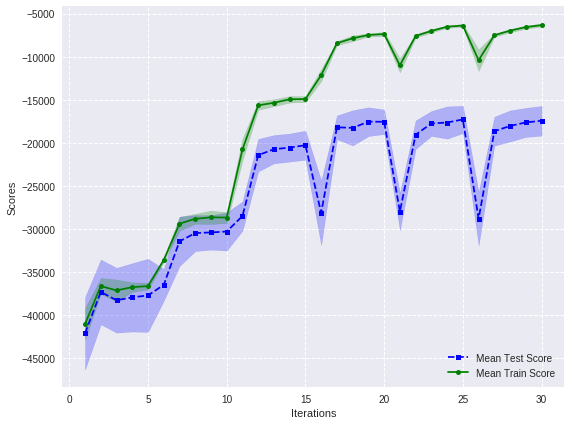

In [142]:
pretty_print_split_results(grid_search.cv_results_, len(grid_search.cv_results_['params']))

In [0]:
best_model = grid_search.best_estimator_
y_train_pred= best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [144]:
mae_train = mean_absolute_error(y_pred=y_train_pred, y_true=y_train)
mae_test  = mean_absolute_error(y_pred=y_test_pred, y_true=y_test)
msg = "Mean Absolute Error with Random Forest model from grid search: {}"
print(msg.format(mae_train))
print(msg.format(mae_test))
print("Model train score: {}".format(best_model.score(X_train, y_train)))
print("Model test score: {}".format(best_model.score(X_test, y_test)))

Mean Absolute Error with Random Forest model from grid search: 6145.599502513592
Mean Absolute Error with Random Forest model from grid search: 20287.455787501014
Model train score: 0.9814620724881161
Model test score: 0.8210394245353742
